# Ligand-based screening-neural networks

## 目标 ¶

近年来，机器学习和深度学习在药物研究中的应用在解决药物发现中的各种问题上显示出有希望的结果。在本讲义中，我们将熟悉神经网络的基础知识。我们将学习如何构建一个简单的两层神经网络，并在 ChEMBL 数据的一个子集上对其进行训练，以预测化合物对 VEGFR2（感兴趣的目标）的 pIC50 值。此外，我们从外部未标记的数据集中选择了三种化合物，这些化合物被预测对该激酶活性最高。

### 内容在理论中 ¶

-  生物背景
  -  VEGFR2 激酶
  - 复合活动指标
  -  分子编码
-  神经网络
  - 什么是神经网络？
  -  激活函数
  -  损失函数
- 训练神经网络
-  Keras 工作流程
- 神经网络的优势和应用

###  内容在实用篇中

-  数据准备
-  定义神经网络
-  训练模型
- 评估与预测在测试集上
  -  散点图
- 预测外部/未标记数据
  - 选择前 3 个化合物

### 生物背景 ¶

####  EGFR 激酶

- VEGFR2 是一种存在于细胞膜上的跨膜蛋白/受体。它是 ErbB 受体家族的成员。
- VEGFR2 在控制正常细胞生长、细胞凋亡和其他细胞功能中起着重要作用。
- 它通过配体与其细胞外域结合而被激活，激活后 VEGFR2 从非活性单体形式转变为活性同源二聚体。
- VEGFR2 受体在各种肿瘤或癌症中上调，因此 VEGFR2 抑制是一种可能阻止癌细胞生长的生物治疗方法。

#### 复合活动测量指标

- IC50 是药物的半数最大抑制浓度，表示需要多少药物才能将生物过程抑制一半。
- pIC50 是 IC50 值的负对数。它比 IC50 值更容易理解，是衡量化合物活性的常用指标01。

####  分子编码

对于机器学习算法，分子需要转换为机器可读的格式，例如特征列表。在这个笔记本中，使用了分子指纹。

分子指纹通过位串编码化学结构和分子特征，其中每个位置上的“1”代表特征的存在，“0”代表特征的缺失。常用的指纹之一是分子访问系统指纹（MACCS Keys），它是一种 166 位的结构键描述符，其中每个位都与一个 SMARTS 模式相关联，用于编码特定的亚结构（详见 Talktorial T004 以获取更多详细信息）。

In [1]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# 消除警告信息
import warnings
warnings.filterwarnings('ignore')



#  防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline


2024-11-21 12:22:14.150796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)



/Users/wangyang/Desktop/AIGC-in-drug-design/04_Ligand-based screening-neural_networks/data


In [4]:
# Load data
df = pd.read_csv(HERE / '../01_Molecular_representation/data/bioactivities_compounds_VEGFR2.csv')
df = df.reset_index(drop=True)

In [5]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  200 non-null    object 
 1   IC50                200 non-null    float64
 2   units               200 non-null    object 
 3   smiles              200 non-null    object 
 4   pIC50               200 non-null    float64
dtypes: float64(2), object(3)
memory usage: 7.9+ KB


In [6]:
# Look at head
df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL5189340,0.023,nM,CN(C)c1ccc(/C=N/NC(=O)Cn2nc(Cc3ccc(Cl)cc3)c3cc...,10.638272
1,CHEMBL429743,0.030,nM,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5)cccc4c...,10.522879
2,CHEMBL5186748,0.120,nM,CNC(=O)c1cc(Oc2ccc(NC(=O)c3nn(-c4ccc(Cl)cc4)cc...,9.920819
3,CHEMBL3093581,0.140,nM,O=C(Nc1ccc(Oc2ccc3nc(NC(=O)C4CC4)cn3c2)c(F)c1)...,9.853872
4,CHEMBL3586072,0.140,nM,CNC(=O)c1ccc(-c2ccc(NC(=O)Nc3cc(Br)cc(C(F)(F)F...,9.853872


In [7]:
# Keep necessary columns
chembl_df = df[["smiles", "pIC50"]]
chembl_df.head()

,smiles,pIC50
0,CN(C)c1ccc(/C=N/NC(=O)Cn2nc(Cc3ccc(Cl)cc3)c3cc...,10.638272
1,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5)cccc4c...,10.522879
2,CNC(=O)c1cc(Oc2ccc(NC(=O)c3nn(-c4ccc(Cl)cc4)cc...,9.920819
3,O=C(Nc1ccc(Oc2ccc3nc(NC(=O)C4CC4)cn3c2)c(F)c1)...,9.853872
4,CNC(=O)c1ccc(-c2ccc(NC(=O)Nc3cc(Br)cc(C(F)(F)F...,9.853872


**分子编码**

我们将 SMILES 字符串转换为数值数据以应用神经网络。我们将使用 MACCS 键来编码化合物。MACCS 键是一个 166 位的结构键描述符，其中每个位都与一个 SMARTS 模式相关联，用于编码特定的亚结构。

MACCS 键的生成方法是：

1. 首先，将化合物转换为 RDKit 格式。
2. 然后，使用 RDKit 的 `GetMorganFingerprintAsBitVect` 函数生成 MACCS 键。
3. 将 MACCS 键转换为 NumPy 数组。



In [8]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

将所有 SMILES 字符串转换为 MACCS 指纹。

In [10]:
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (200, 3)


,smiles,pIC50,fingerprints_df
0,CN(C)c1ccc(/C=N/NC(=O)Cn2nc(Cc3ccc(Cl)cc3)c3cc...,10.638272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5)cccc4c...,10.522879,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CNC(=O)c1cc(Oc2ccc(NC(=O)c3nn(-c4ccc(Cl)cc4)cc...,9.920819,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


接下来，我们定义 x，特征，以及 y，用于训练模型的目标数据。在我们的案例中，特征是位向量，目标值是分子的 pIC50 值。

我们使用 scikit-learn 库中的 train_test_split 将数据分为 70%的训练数据和 30%的测试数据。

In [11]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (140,)
Shape of test data: (60,)


### 定义神经网络 ¶

A keras 模型通过指定隐藏层中的神经元数量和激活函数作为参数来定义。为了我们的目的，我们定义了一个具有两个隐藏层的模型。我们在隐藏层中使用 ReLU，在输出层上使用线性函数，因为目标是预测 pIC50 值。最后，我们使用均方误差作为损失参数和 adam 作为优化器来编译模型。

In [12]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

###  训练模型 ¶

我们尝试不同的迷你批量大小并绘制相应的损失图。

In [13]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

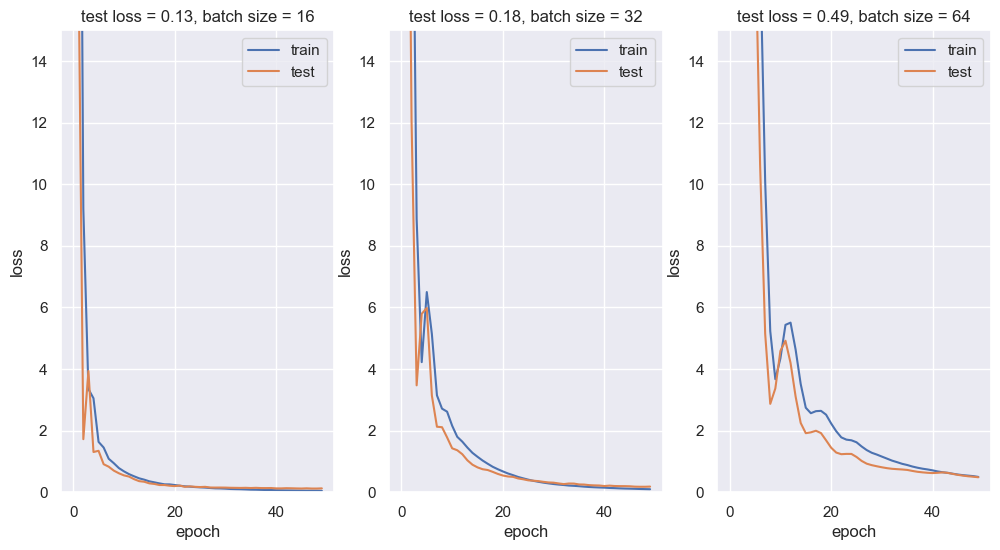

In [15]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / "loss_plot.png", dpi=300)
plt.show()

从上面的损失图中可以看出，批量大小为 16 似乎能给出最佳性能。

A ModelCheckpoint 回调用于在某个间隔内保存最佳模型/权重（在检查点文件中），以便模型/权重可以保存为当前状态或稍后加载以继续从保存的状态进行训练。

现在，我们以 16 个批次的规模训练模型（因为如上图所示，它具有最低的测试损失），并将给出最佳性能的权重保存在文件 `best_weights.hdf5` 中。

In [16]:
# Save the trained model
filepath = DATA / "best_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

### 评估与预测在测试集上

评估()方法用于检查我们模型的性能。它报告损失（在我们的情况下是 mse）以及评估指标（mse 和 mae）。

In [17]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.14
 mse (same as loss): 0.14
 mae: 0.29


测试集上的平均绝对误差如下 1.0 ，考虑到 pIC50 值的范围，这个误差相当低。

我们现在预测测试数据中的 pIC50 值。

In [18]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

2/2 [==============================] - 0s 2ms/step
9.11
9.63
9.66
9.12
9.35


#### 散点图 ¶

为了可视化预测结果，我们在测试集上绘制预测值与真实 pIC50 值的关系图。

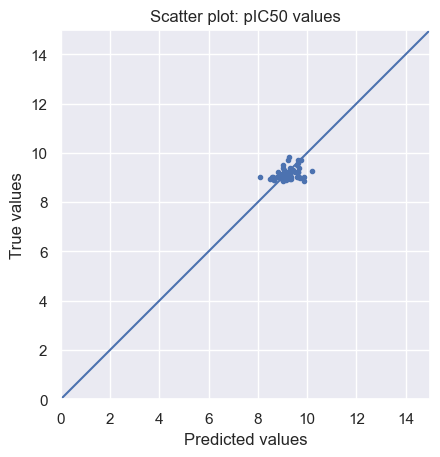

In [20]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / "scatter_plot.png", dpi=300)
plt.show()

如您所见，预测值与真实值之间存在正线性关系，但拟合程度远非完美。

### 预测外部/未标记数据 ❤️❤️❤️

我们使用训练好的神经网络预测来自 `test.csv` 文件的无标签化合物的 pIC50 值。

In [21]:
# Load external/unlabeled data set,这个数据需要自己去生成的，一般生成新的数据拿来预测的❤️，需要自己加载进去的
external_data = pd.read_csv(DATA / "test.csv", index_col=0)
external_data = external_data.reset_index(drop=True)
external_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangyang/Desktop/AIGC-in-drug-design/04_Ligand-based screening-neural_networks/data/test.csv'

我们使用相同的 smiles_to_fp 函数，将 SMILES 字符串转换为 MACCS 指纹。



In [ ]:
# Convert SMILES strings to MACCS fingerprints
external_data["fingerprints_df"] = external_data["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", external_data.shape)
external_data.head(3)

注意：为确保结果的可重复性，我们将一个模型保存为 `ANN_model.hdf5` ，其结构与上述相同。尽管模型相同，但由于随机梯度算法中的随机性，从一次模拟到另一次模拟保存的权重可能不同。我们使用 load_model()函数加载 ANN 模型权重。

In [ ]:
# Load model
model = load_model(DATA / "ANN_model.hdf5", compile=False)

In [ ]:
# Prediction on external/unlabeled data
predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(3)

In [ ]:
# Save the predicted values in a csv file in the data folder
predicted_pIC50_df.to_csv(DATA / "predicted_pIC50_df.csv")

#### 选择前 3 个化合物 ¶

我们选择预测 pIC50 值最高的 3 个化合物，这些化合物可以作为潜在的 VEGRF2 抑制剂进一步研究。

In [ ]:
# Select top 3 drugs
predicted_pIC50_df = pd.read_csv(DATA / "predicted_pIC50_df.csv", index_col=0)
top3_drug = predicted_pIC50_df.nlargest(3, "predicted_pIC50")
top3_drug

In [ ]:
# Draw the drug molecules
highest_pIC50 = predicted_pIC50_df["canonical_smiles"][top3_drug.index]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug["predicted_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_EGFR]

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / "top3_drugs.png", dpi=300)
plt.show()